<a href="https://colab.research.google.com/github/xanasa14/ShoeClassificatorFITVSFIT_GENERATOR/blob/master/shoesfit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install tensorflow_hub
from __future__ import absolute_import, division, print_function, unicode_literals
import matplotlib.pylab as plt
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import pandas as pd

In [0]:
pd.set_option("display.precision", 8)


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
data_root='/content/drive/My Drive/shoe_images'


In [6]:
IMAGE_SHAPE = (224, 224)
TRAINING_DATA_DIR = str(data_root)
print(TRAINING_DATA_DIR);
datagen_kwargs = dict(rescale=1./255, validation_split=.20)
valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
valid_generator = valid_datagen.flow_from_directory(
TRAINING_DATA_DIR,
subset="validation",
shuffle=True,
target_size=IMAGE_SHAPE
)
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
train_generator = train_datagen.flow_from_directory(
TRAINING_DATA_DIR,
subset="training",
shuffle=True,
target_size=IMAGE_SHAPE)

/content/drive/My Drive/shoe_images
Found 149 images belonging to 5 classes.
Found 601 images belonging to 5 classes.


In [7]:
image_batch_train, label_batch_train = next(iter(train_generator))
print("Image batch shape: ", image_batch_train.shape)
print("Label batch shape: ", label_batch_train.shape)
dataset_labels = sorted(train_generator.class_indices.items(), key=lambda pair:pair[1])
dataset_labels = np.array([key.title() for key, value in dataset_labels])
print(dataset_labels)

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 5)
['Nike_Air_Max_Plus' 'Nike_Court_Royale' 'Nike_Downshifter'
 'Nike_Md_Runner' 'Nike_Nightgazer']


In [8]:
model = tf.keras.Sequential([
hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4",
output_shape=[1280],
trainable=False),
tf.keras.layers.Dropout(0.4),
tf.keras.layers.Dense(train_generator.num_classes, activation='softmax')
])
model.build([None, 224, 224, 3])
model.summary()
model.compile(
optimizer=tf.keras.optimizers.Adam(),
loss='categorical_crossentropy',
metrics=['acc'])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     multiple                  2257984   
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [13]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
steps_per_epoch = np.ceil(train_generator.samples/train_generator.batch_size)
val_steps_per_epoch = np.ceil(valid_generator.samples/valid_generator.batch_size)
hist = model.fit(
train_generator,
epochs=10,
verbose=1,

steps_per_epoch=steps_per_epoch,
validation_data=valid_generator,
validation_steps=val_steps_per_epoch).history

Epoch 1/10
 1/19 [>.............................] - ETA: 44s - loss: 0.3103 - acc: 0.8750

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


19/19 [==============================] - 40s 2s/step - loss: 0.2770 - acc: 0.9168 - val_loss: 0.3129 - val_acc: 0.9262
Epoch 2/10
19/19 [==============================] - 37s 2s/step - loss: 0.3061 - acc: 0.9002 - val_loss: 0.3040 - val_acc: 0.9262
Epoch 3/10
19/19 [==============================] - 37s 2s/step - loss: 0.2561 - acc: 0.9018 - val_loss: 0.2893 - val_acc: 0.9195
Epoch 4/10
19/19 [==============================] - 37s 2s/step - loss: 0.2547 - acc: 0.9135 - val_loss: 0.2948 - val_acc: 0.9396
Epoch 5/10
19/19 [==============================] - 37s 2s/step - loss: 0.2467 - acc: 0.9185 - val_loss: 0.2734 - val_acc: 0.9329
Epoch 6/10
19/19 [==============================] - 37s 2s/step - loss: 0.2157 - acc: 0.9418 - val_loss: 0.2644 - val_acc: 0.9463
Epoch 7/10
19/19 [==============================] - 37s 2s/step - loss: 0.2280 - acc: 0.9201 - val_loss: 0.2687 - val_acc: 0.9195
Epoch 8/10
19/19 [==============================] - 37s 2s/step - loss: 0.2288 - acc: 0.9318 - val_lo

In [14]:
val_image_batch, val_label_batch = next(iter(valid_generator))
true_label_ids = np.argmax(val_label_batch, axis=-1)
print("Validation batch shape:", val_image_batch.shape)
tf_model_predictions = model.predict(val_image_batch)
tf_pred_dataframe = pd.DataFrame(tf_model_predictions)
tf_pred_dataframe.columns = dataset_labels
print("Prediction results for the first elements")
tf_pred_dataframe.head()

Validation batch shape: (32, 224, 224, 3)
Prediction results for the first elements


,Nike_Air_Max_Plus,Nike_Court_Royale,Nike_Downshifter,Nike_Md_Runner,Nike_Nightgazer
0,0.98570919,0.00008776,0.00907757,0.00512383,0.00000162
1,0.00005771,0.98259705,0.00170557,0.01563912,0.00000047
2,0.00105870,0.57491857,0.16999975,0.25393400,0.00008901
3,0.00175864,0.44288164,0.37954640,0.17574947,0.00006385
4,0.10580943,0.02802817,0.82963121,0.03635496,0.00017620


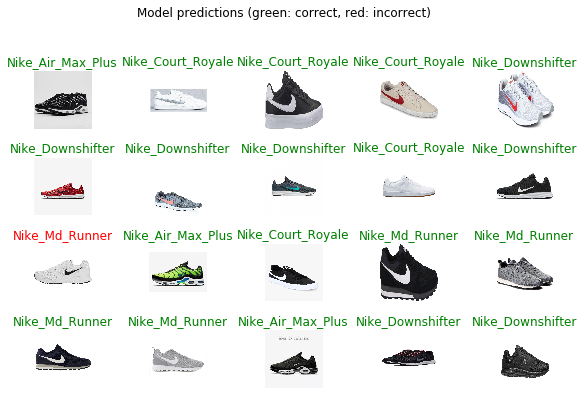

In [15]:
predicted_ids = np.argmax(tf_model_predictions, axis=-1)
predicted_labels = dataset_labels[predicted_ids]
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(20):
  plt.subplot(6,5,n+1)
  plt.imshow(val_image_batch[n])
  color = "green" if predicted_ids[n] == true_label_ids[n] else "red"
  plt.title(predicted_labels[n].title(), color=color)
  plt.axis('off')
  plt.suptitle("Model predictions (green: correct, red: incorrect)")